### Ship sailing strategies with various combinations of payloads and velocities for passing a bottleneck waterway section

### Steps before sailing: 
- Giving a sailing route, in which there is an section with limited water depth (h_min)
- Listing a group of possible actual draughts depending on the limited water depth and minimum operating draughts
- Using the T2v function to find out the corresponding velocities the ship can sail with to safely pass the bottlenek without grounding
- Displaying the possible actual draughts with its maximum sailing velocities and suggesting several sailing strategies.

### Steps while sailing: 
- c

In [1]:
import functools

# package(s) related to time, space and id
import logging
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')



### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).

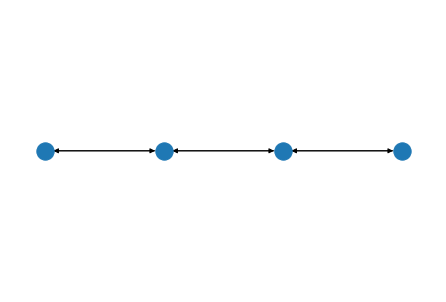

In [2]:
FG = nx.DiGraph()
nodes = []
path = []

Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

data_node_1 = {"name": "Node 1",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_2 = {"name": "Node 2",
               "geometry": shapely.geometry.Point(0.8983, 0)}  # 0.8983 degree =100km
data_node_3 = {"name": "Node 3",
               "geometry": shapely.geometry.Point(1.7966, 0)}   # 1.7966 degree =200km
data_node_4 = {"name": "Node 4",
               "geometry": shapely.geometry.Point(2.6949, 0)}    # 2.6949 degree =300km

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)
node_3 = Node(**data_node_3)
node_4 = Node(**data_node_4)

nodes = [node_1, node_2, node_3, node_4]

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

path = [[node_1, node_2], # From node 1 to node 2
        [node_2, node_3], # From node 2 to node 3
        [node_3, node_4], # From node 3 to node 4
        [node_4, node_3], # From node 4 to node 3
        [node_3, node_2], # From node 3 to node 2
        [node_2, node_1]] # From node 2 to node 1

for edge in path:
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": 6})
    
middle_edges = [
    (node_2.name, node_3.name),
    (node_3.name, node_2.name)
]
for e in middle_edges:
    edge = FG.edges[e]
    edge['Info']['GeneralDepth'] = 3

# env.FG = FG
nx.draw(FG, positions)
plt.show()

In [3]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 1', 'Node 2') is 6
General depth for edge ('Node 2', 'Node 3') is 3
General depth for edge ('Node 2', 'Node 1') is 6
General depth for edge ('Node 3', 'Node 4') is 6
General depth for edge ('Node 3', 'Node 2') is 3
General depth for edge ('Node 4', 'Node 3') is 6


### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption.  

In [4]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.HasContainer,  # needed to calculate filling degree for draught
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [5]:
# Create a dict with all important settings
data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 1,  # m/s
               "type": 'Dortmund-Eems (L <= 74 m)', # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "capacity": 2500,   # maximum designed payload
               "level":2500,     # actual payload
               "H_e": None, 
               "H_f": None, 
               "T": None,
               "P_installed": 1750.0,   
               "P_tot_given": 1750, # kW
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
               "current_year":None
              }               

vessel = TransportResource(**data_vessel)
print('parameters not used', vessel.metadata)


parameters not used {}


### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [6]:
path = nx.dijkstra_path(FG, node_1.name, node_4.name)

In [7]:
input_data = {'V_s': [1.0, 1.5],'T_strategy': [2.0, 1.8]}
input_data

{'V_s': [1.0, 1.5], 'T_strategy': [2.0, 1.8]}

In [8]:
def T2v(vessel, h_min, bounds=(0, 10)):
    """Compute vessel velocity given the minimum water depth and possible actual draught 
    
    bounds is the limits where to look for a solution for the velocity [m/s]
    returns velocity [m/s]
    """
    def seek_v_given_T(v, vessel, h_min):
        """function to optimize"""
        # minimum water depth from the edge
        vessel.__dict__
        h_min = vessel.h_min
        vessel.v = v
        vessel.static_ukc
        # compute the maximum draught a vessel can have to pass the minimum water depth section, 
        # considering the maximum squat while sailing in limited water depth.
        T_strategy = vessel.T_strategy_consider_squat(v = v)
       
        # compute difference between T_strategy and possible actual draught
        diff = T_strategy - vessel.T
        logger.debug(f'optimizing for v: {v}, T_strategy: {T_strategy}, T: {vessel.T}')
        
        return diff ** 2        
        
    # fill in some of the parameters that we already know
    fun = functools.partial(seek_v_given_T, vessel=vessel, h_min = h_min)       
       # lookup a minimum
    fit = scipy.optimize.minimize_scalar(fun, bounds=bounds, method='bounded')
    # check if we found a minimum
    if not fit.success:
        raise ValueError(fit)
    logger.debug(f"fit: {fit}")
    v, T_strategy = fit.x, fit.fun
    print(v, T_strategy)
    return v, T_strategy

In [9]:
# def T2v(vessel, h_min, bounds=(0, 10)):
#     """Compute vessel velocity given an edge and payload (reprented by T)
    
#     bounds is the limits where to look for a solution for the velocity [m/s]
#     returns velocity [m/s]
#     """
#     def seek_v_given_T(v, vessel):
#         """function to optimize"""
#         # water depth from the edge
#         h_min = vessel.h_min
#         vessel.v = v
        
#         # compute actual draught and payload (dynamic_ukc included in this step calculation)
#         (actual_T, payload)= vessel.calculate_actual_T_and_payload(h_min)
#        # compute difference between power setting by captain and power needed for velocity
    
#         diff = actual_T - vessel.T
#         logger.debug(f'optimizing for v: {v}, actual_T: {actual_T}, T: {vessel.T}')
        
#         return diff ** 2        
        
#     # fill in some of the parameters that we already know
#     fun = functools.partial(seek_v_given_T, vessel=vessel)       
#        # lookup a minimum
#     fit = scipy.optimize.minimize_scalar(fun, bounds=bounds, method='bounded')
#     # check if we found a minimum
#     if not fit.success:
#         raise ValueError(fit)
#     logger.debug(f"fit: {fit}")
#     v, T = fit.x, fit.fun
#     # print(v, T)
#     return v, T

### Run simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [10]:
def run_simulation(V_s, T_strategy):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel.T_strategy = T_strategy
    v, T_strategy = T2v(vessel, h_min=2.5)
    # Start the simulation
    env.process(vessel.move())
    env.run()
    print('v: {:.2f} m'.format(v), T)
    return vessel

In [ ]:
# create empty plot data
plot_data = {}

# loop through the various input data
for index, value in enumerate(input_data['V_s']):
    
    # Run a basic simulation with V_s and P_tot_given combi
    vessel = run_simulation(input_data['V_s'][index],input_data['T_strategy'][index])
    
    # create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    # create dataframe from energy calculation computation
    df = pd.DataFrame.from_dict(energycalculation.energy_use)